In [1]:
% matplotlib inline
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.pyplot import spy
from sklearn.metrics import roc_auc_score
from torch import nn

from data_loading import load_mnist
from variational_dropout import SparseLinear, Sgvb

In [2]:
def show_sparsity(t):
    spy(t, precision=1e-2)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
X_train, y_train, X_test, y_test = load_mnist()

In [5]:
class SparseNet(nn.Module):
    def __init__(self):
        super(SparseNet, self).__init__()
        self.fc1 = SparseLinear(28*28, 256)
        self.fc2 = SparseLinear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
net = SparseNet().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

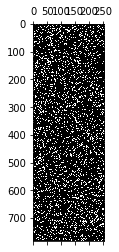

In [7]:
show_sparsity(net.fc1.W.abs().detach().to('cpu').numpy())

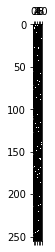

In [8]:
show_sparsity(net.fc2.W.abs().detach().to('cpu').numpy())

In [9]:
steps = 1500
batch = 100
elbos = []
sgvb = Sgvb(len(y_train), batch)
for i in range(steps):
    optimizer.zero_grad()
    indices = np.random.choice(len(y_train), batch)
    X, y = X_train[indices].to(device), y_train[indices].to(device)
    output = net(X)
    loss = -sgvb.evaluate(output, y, net)
    loss.backward()
    optimizer.step()
    elbos.append(-loss.item())

Text(0,0.5,'ELBO')

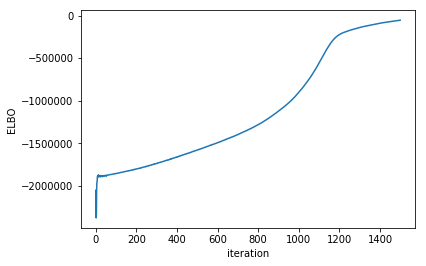

In [10]:
plt.plot(np.arange(len(elbos)), elbos)
plt.xlabel('iteration')
plt.ylabel('ELBO')

In [11]:
y_pred = net(X_test.to(device)).softmax(dim=1).detach().to('cpu')
one_hot = np.zeros(y_test.shape + (10,))
one_hot[np.arange(len(y_test)), y_test] = 1

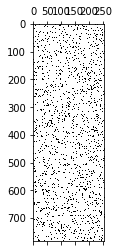

In [12]:
show_sparsity(net.fc1.W.abs().detach().to('cpu').numpy())

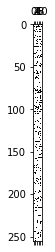

In [13]:
show_sparsity(net.fc2.W.abs().detach().to('cpu').numpy())

In [14]:
roc_auc_score(one_hot, y_pred)

0.98157345257576123

pred=2, true=2


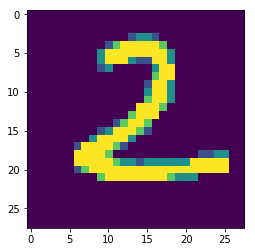

In [15]:
index = np.random.choice(len(y_test))
x, y = X_test[index].to(device), y_test[index].to(device)
out = net(x).detach()
print(f"pred={np.argmax(out).item()}, true={y}")
plt.imshow(x)